# Conditional Disentangled VAE Interactive Notebook 🧠🔀📊

This notebook provides an interactive interface for exploring a **Conditional Disentangled VAE** trained on multi-modal medical imaging data.

## Advanced Features:
- 🎯 **Multi-modal reconstruction** across different medical imaging types
- 🔄 **Conditional generation** by modality (ChestMNIST, PathMNIST, etc.)
- 🎨 **Class-conditional generation** within each modality
- 🔀 **Disentangled latent space** exploration (shared vs modality-specific)
- 📊 **Cross-modal comparisons** and analysis
- 🧪 **Modality transfer** experiments

---

## 1. Import Required Libraries

In [12]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Add the project root to the Python path
# Get the notebook directory and go up one level to the project root
notebook_dir = Path().resolve()
project_root = notebook_dir.parent  # Go up one level from notebooks/ to project root
print(f"📁 Notebook directory: {notebook_dir}")
print(f"📁 Project root: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ Added project root to Python path")

# Import project modules
from src.models import ConditionalVAE, DisentangledConditionalVAE
from src.data import MedMNISTDataModule  # Use the existing data module
from src.utils import compute_reconstruction_metrics

print("✅ All libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🎯 Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

📁 Notebook directory: /Users/parsa/Projects/TUDa/DGM/medvae-disentangled-multimodal/notebooks
📁 Project root: /Users/parsa/Projects/TUDa/DGM/medvae-disentangled-multimodal
✅ All libraries imported successfully!
🔧 PyTorch version: 2.7.1
🎯 Device available: CPU


## 2. Configuration and Setup

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

# Model configuration for Conditional/Disentangled VAE
DISENTANGLED_CONFIG = {
    "num_modalities": 5,
    "shared_latent_dim": 8,
    "modality_latent_dim": 8,
    "resolution": 28,
    "hidden_channels": 128,
    "ch_mult": (1, 2, 4, 8),
    "num_res_blocks": 2,
    "attn_resolutions": [16],
    "modality_separation_weight": 0.1,
    "contrastive_weight": 0.05,
}

CONDITIONAL_CONFIG = {
    "modalities": ["chestmnist", "pathmnist", "octmnist", "pneumoniamnist", "dermamnist"],
    "condition_dim": 5,
    "condition_method": "concat",
    "input_channels": 3,  # Max channels across modalities
    "latent_dim": 128,
    "hidden_channels": 128,
    "resolution": 28,
    "ch_mult": (1, 2, 4, 8),
    "num_res_blocks": 2,
    "attn_resolutions": [16],
}

# Modality information
MODALITIES = {
    0: {"name": "ChestMNIST", "channels": 1, "description": "Chest X-Ray Images", "classes": ["Normal", "Abnormal"]},
    1: {"name": "PathMNIST", "channels": 3, "description": "Colon Pathology Images", "classes": ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]},
    2: {"name": "OCTMNIST", "channels": 3, "description": "Retinal OCT Images", "classes": ["CNV", "DME", "DRUSEN", "NORMAL"]},
    3: {"name": "PneumoniaMNIST", "channels": 1, "description": "Pneumonia X-Ray Images", "classes": ["Normal", "Pneumonia"]},
    4: {"name": "DermaMNIST", "channels": 3, "description": "Dermatoscope Images", "classes": ["ACK", "BCC", "MEL", "NEV", "PIH", "SEK", "UNK"]},
}

# Paths
CHECKPOINTS_DIR = Path("logs/checkpoints")
DATA_DIR = Path("data")

print("⚙️ Configuration loaded successfully!")
print(f"📁 Checkpoints directory: {CHECKPOINTS_DIR}")
print(f"🏥 Available modalities: {[info['name'] for info in MODALITIES.values()]}")

🖥️  Using device: cpu
⚙️ Configuration loaded successfully!
📁 Checkpoints directory: logs/checkpoints
🏥 Available modalities: ['ChestMNIST', 'PathMNIST', 'OCTMNIST', 'PneumoniaMNIST', 'DermaMNIST']


## 3. Load Pre-trained Model

In [3]:
class LegacyDisentangledConditionalVAE(DisentangledConditionalVAE):
    """
    Legacy DisentangledConditionalVAE with the original quick architecture parameters.
    This matches the older checkpoints that were saved with different parameters.
    """
    def __init__(self, **kwargs):
        # Override default parameters to match the original quick architecture
        legacy_config = {
            "num_modalities": 5,
            "shared_latent_dim": 8,
            "modality_latent_dim": 8,
            "resolution": 28,
            "hidden_channels": 32,     # Original smaller architecture
            "ch_mult": (1, 2, 4),      # Fewer downsampling stages
            "num_res_blocks": 1,       # Single ResNet block per stage
            "attn_resolutions": [],    # No attention to save parameters
            "dropout": 0.1,
            "use_linear_attn": False,
            "attn_type": "vanilla",
            "double_z": True,
            "modality_separation_weight": 0.1,
            "contrastive_weight": 0.05,
        }
        # Update with any provided kwargs
        legacy_config.update(kwargs)
        super().__init__(**legacy_config)

def load_conditional_model(checkpoint_path=None, model_type="disentangled", use_legacy=False):
    """Load a conditional VAE model with optional checkpoint weights."""
    
    if use_legacy:
        # Use the original smaller architecture for legacy checkpoints
        if model_type == "disentangled":
            model = LegacyDisentangledConditionalVAE()
            config_used = {
                "shared_latent_dim": 8,
                "modality_latent_dim": 8,
                "hidden_channels": 32
            }
            print("🔄 Using legacy DisentangledConditionalVAE architecture (hidden_channels=32)")
        else:
            # For conditional VAE, we'd need a legacy version too if needed
            model = ConditionalVAE(**CONDITIONAL_CONFIG)
            config_used = CONDITIONAL_CONFIG
    elif model_type == "disentangled":
        model = DisentangledConditionalVAE(**DISENTANGLED_CONFIG)
        config_used = DISENTANGLED_CONFIG
    elif model_type == "conditional":
        model = ConditionalVAE(**CONDITIONAL_CONFIG)
        config_used = CONDITIONAL_CONFIG
    else:
        raise ValueError(f"Unknown model type: {model_type}. Choose 'disentangled' or 'conditional'")
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"📂 Loading checkpoint from: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            
            # Extract model weights from Lightning checkpoint
            model_state_dict = {}
            for key, value in checkpoint["state_dict"].items():
                if key.startswith("model."):
                    model_state_dict[key[6:]] = value  # Remove "model." prefix
            
            model.load_state_dict(model_state_dict)
            print("✅ Model weights loaded successfully!")
        except RuntimeError as e:
            if "size mismatch" in str(e):
                print("⚠️ Architecture mismatch detected! Trying legacy architecture...")
                # Try loading with legacy architecture
                if model_type == "disentangled":
                    model = LegacyDisentangledConditionalVAE()
                    model.to(device)  # Move to device before loading
                    
                    model_state_dict = {}
                    for key, value in checkpoint["state_dict"].items():
                        if key.startswith("model."):
                            model_state_dict[key[6:]] = value
                    
                    model.load_state_dict(model_state_dict)
                    print("✅ Model weights loaded successfully with legacy architecture!")
                    
                    config_used = {
                        "shared_latent_dim": 8,
                        "modality_latent_dim": 8,
                        "hidden_channels": 32
                    }
                else:
                    raise e
            else:
                raise e
        except Exception as e:
            print(f"⚠️ Error loading weights: {e}")
            print("Using randomly initialized weights...")
    else:
        print("⚠️ No checkpoint provided - using randomly initialized weights")
    
    model.to(device)
    model.eval()
    
    print(f"🧠 Model loaded: {model.__class__.__name__}")
    print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    if model_type == "disentangled":
        print(f"🔀 Shared latent dim: {config_used.get('shared_latent_dim', 'N/A')}")
        print(f"🎯 Modality latent dim: {config_used.get('modality_latent_dim', 'N/A')}")
        print(f"🏗️ Hidden channels: {config_used.get('hidden_channels', 'N/A')}")
    
    return model

# Model selection widget
model_type_widget = widgets.Dropdown(
    options=[('Disentangled VAE', 'disentangled'), ('Conditional VAE', 'conditional')],
    value='disentangled',
    description='Model Type:'
)

checkpoint_path_widget = widgets.Text(
    value=f'{project_root}/logs/checkpoints/disentangled_multi_modal_cvae_quick_final.ckpt',  # Default path
    placeholder='Path to checkpoint file (.ckpt)',
    description='Checkpoint:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px')
)

load_button = widgets.Button(description="Load Model", button_style='primary')
output_widget = widgets.Output()

def on_load_clicked(b):
    with output_widget:
        clear_output()
        global model, model_type
        model_type = model_type_widget.value
        checkpoint = checkpoint_path_widget.value if checkpoint_path_widget.value.strip() else None
        model = load_conditional_model(checkpoint, model_type)

load_button.on_click(on_load_clicked)

# Display widgets
display(widgets.VBox([
    widgets.HBox([model_type_widget, load_button]),
    checkpoint_path_widget,
    output_widget
]))

# Initialize with default model and checkpoint
model_type = 'disentangled'
checkpoint_path = f'{project_root}/logs/checkpoints/disentangled_multi_modal_cvae_quick_final.ckpt'
model = load_conditional_model(checkpoint_path, model_type)

📂 Loading checkpoint from: /Users/parsa/Projects/TUDa/DGM/medvae-disentangled-multimodal/logs/checkpoints/disentangled_multi_modal_cvae_quick_final.ckpt
⚠️ Architecture mismatch detected! Trying legacy architecture...
✅ Model weights loaded successfully with legacy architecture!
🧠 Model loaded: LegacyDisentangledConditionalVAE
📊 Total parameters: 2,744,671
🔀 Shared latent dim: 8
🎯 Modality latent dim: 8
🏗️ Hidden channels: 32


## 4. Load Multi-Modal Dataset

In [4]:
import numpy as np
from torch.utils.data import DataLoader
import ipywidgets as widgets
from IPython.display import display, clear_output

# Available datasets
DATASETS = {
    'chestmnist': 'data/chestmnist.npz',
    'pathmnist': 'data/pathmnist.npz', 
    'octmnist': 'data/octmnist.npz',
    'pneumoniamnist': 'data/pneumoniamnist.npz',
    'dermamnist': 'data/dermamnist.npz'
}

# Data loading widgets
dataset_selection = widgets.SelectMultiple(
    options=list(DATASETS.keys()),
    value=['chestmnist', 'pathmnist', 'octmnist'],  # Default selection
    description='Datasets:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px', height='120px')
)

batch_size_widget = widgets.IntSlider(
    value=32,
    min=8,
    max=128,
    step=8,
    description='Batch Size:',
    style={'description_width': 'initial'}
)

load_data_button = widgets.Button(
    description='Load Selected Datasets',
    button_style='primary'
)

# Output area
data_output = widgets.Output()

def load_multimodal_data(b=None):
    with data_output:
        clear_output(wait=True)
        try:
            selected_datasets = list(dataset_selection.value)
            if not selected_datasets:
                print("Please select at least one dataset.")
                return
            
            print(f"Loading datasets: {selected_datasets}")
            
            # Use the existing MedMNISTDataModule for multi-modal loading
            data_path = project_root / "data"
            
            datamodule = MedMNISTDataModule(
                dataset_names=selected_datasets,  # Pass multiple datasets
                batch_size=batch_size_widget.value,
                num_workers=2,
                size=28,  # Use 28x28 to match model configuration
                root=str(data_path),
                normalize=True,
                augment_train=False  # Disable augmentation for cleaner visualization
            )
            
            # Setup data
            datamodule.setup()
            
            # Get dataloaders
            train_loader = datamodule.train_dataloader()
            val_loader = datamodule.val_dataloader()
            test_loader = datamodule.test_dataloader()
            
            # Store globally for use in other cells
            global multimodal_datamodule, multimodal_train_loader, multimodal_val_loader, multimodal_test_loader, dataset_info
            multimodal_datamodule = datamodule
            multimodal_train_loader = train_loader
            multimodal_val_loader = val_loader
            multimodal_test_loader = test_loader
            
            dataset_info = {
                'modalities': selected_datasets,
                'modality_to_idx': {mod: idx for idx, mod in enumerate(selected_datasets)},
                'total_train_samples': len(datamodule.train_dataset),
                'total_val_samples': len(datamodule.val_dataset),
                'total_test_samples': len(datamodule.test_dataset),
                'batch_size': batch_size_widget.value
            }
            
            print(f"\n✅ Successfully loaded multi-modal dataset!")
            print(f"Train samples: {len(datamodule.train_dataset)}")
            print(f"Val samples: {len(datamodule.val_dataset)}")
            print(f"Test samples: {len(datamodule.test_dataset)}")
            print(f"Modalities: {selected_datasets}")
            print(f"Batch size: {batch_size_widget.value}")
            
            # Test a sample batch
            sample_batch = next(iter(val_loader))
            if isinstance(sample_batch, (tuple, list)) and len(sample_batch) >= 4:
                images, labels, modalities, modality_indices = sample_batch
                print(f"\n📊 Sample batch info:")
                print(f"Images shape: {images.shape}")
                print(f"Labels shape: {labels.shape}")
                print(f"Modalities shape: {modalities.shape}")
                print(f"Modality indices shape: {modality_indices.shape}")
                print(f"Unique modalities in batch: {torch.unique(modality_indices)}")
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            import traceback
            traceback.print_exc()

load_data_button.on_click(load_multimodal_data)

# Display widgets
print("Select datasets and configure multi-modal data loading:")
display(widgets.VBox([
    dataset_selection,
    batch_size_widget,
    load_data_button,
    data_output
]))

# Auto-load with default settings
print("Loading default datasets...")
load_multimodal_data()

Select datasets and configure multi-modal data loading:


Loading default datasets...


## Quick Test - Multi-Modal Reconstruction Demo

Let's test the DisentangledConditionalVAE functionality with a simple example before using the interactive widgets.

🧪 Testing DisentangledConditionalVAE with multi-modal data...
✅ Multi-modal data is available!
📊 Batch info:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels shape: torch.Size([32, 1])
  Modality indices shape: torch.Size([32])
  Unique modalities in batch: [0]

🔄 Testing reconstruction...
Input images shape: torch.Size([4, 1, 28, 28])
Modality indices: [0, 0, 0, 0]
Labels: [12, 0, 0, 2]
Reconstructed images shape: torch.Size([4, 1, 28, 28])


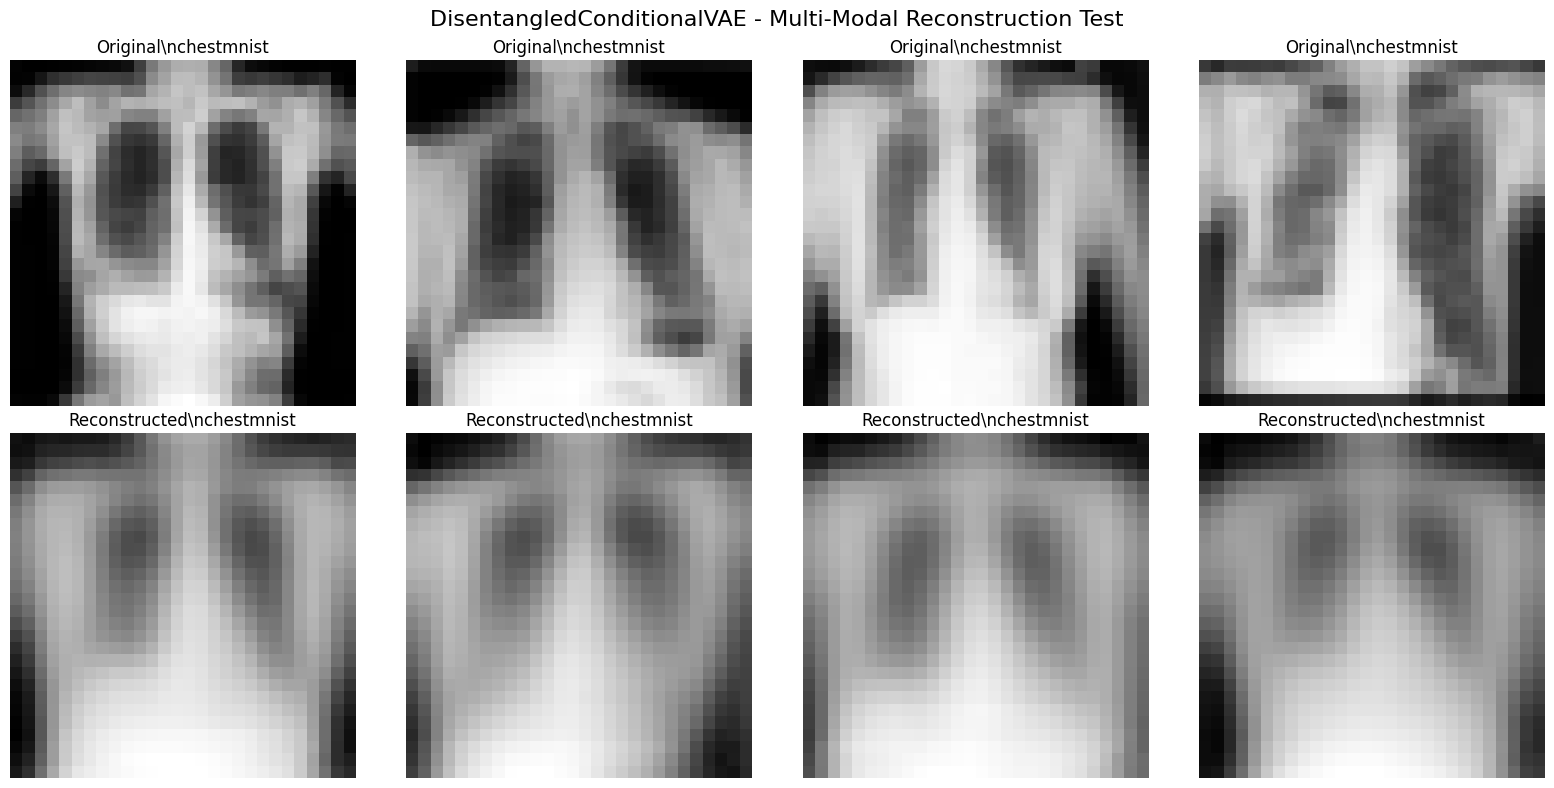


📊 Reconstruction Metrics:
  MSE Loss: 0.208506
  Tested modalities: ['chestmnist', 'chestmnist', 'chestmnist', 'chestmnist']
✅ DisentangledConditionalVAE test completed successfully!


In [7]:
# Quick test of multi-modal reconstruction functionality
print("🧪 Testing DisentangledConditionalVAE with multi-modal data...")

# Wait for data loading to complete and check if data is available
if 'multimodal_val_loader' in globals():
    print("✅ Multi-modal data is available!")
    
    # Get a sample batch
    try:
        sample_batch = next(iter(multimodal_val_loader))
        if isinstance(sample_batch, (tuple, list)) and len(sample_batch) >= 4:
            images, labels, modality_names, modality_indices = sample_batch
            print(f"📊 Batch info:")
            print(f"  Images shape: {images.shape}")
            print(f"  Labels shape: {labels.shape}")
            print(f"  Modality indices shape: {modality_indices.shape}")
            print(f"  Unique modalities in batch: {torch.unique(modality_indices).tolist()}")
            
            # Test reconstruction with the model
            model.eval()
            with torch.no_grad():
                # Take first 4 samples for testing
                test_images = images[:4].to(device)
                test_modality_indices = modality_indices[:4].to(device)
                test_labels = labels[:4].to(device)
                
                print(f"\n🔄 Testing reconstruction...")
                print(f"Input images shape: {test_images.shape}")
                print(f"Modality indices: {test_modality_indices.tolist()}")
                print(f"Labels: {test_labels.squeeze().tolist()}")
                
                # Perform forward pass with correct parameters
                # The DisentangledConditionalVAE forward method expects (x, modality_indices, return_latents)
                outputs = model(test_images, test_modality_indices, return_latents=False)
                reconstruction = outputs["reconstruction"]
                
                print(f"Reconstructed images shape: {reconstruction.shape}")
                
                # Plot comparison
                fig, axes = plt.subplots(2, 4, figsize=(16, 8))
                
                for i in range(4):
                    # Original image
                    orig_img = test_images[i].cpu()
                    if orig_img.shape[0] == 1:  # Grayscale
                        orig_img = orig_img.squeeze()
                        cmap = 'gray'
                    else:  # RGB
                        orig_img = orig_img.permute(1, 2, 0)
                        cmap = None
                    
                    axes[0, i].imshow(orig_img, cmap=cmap)
                    mod_name = dataset_info['modalities'][test_modality_indices[i].item()]
                    axes[0, i].set_title(f'Original\\n{mod_name}')
                    axes[0, i].axis('off')
                    
                    # Reconstructed image
                    recon_img = reconstruction[i].cpu()
                    if recon_img.shape[0] == 1:  # Grayscale
                        recon_img = recon_img.squeeze()
                        cmap = 'gray'
                    else:  # RGB
                        recon_img = recon_img.permute(1, 2, 0)
                        cmap = None
                    
                    axes[1, i].imshow(recon_img, cmap=cmap)
                    axes[1, i].set_title(f'Reconstructed\\n{mod_name}')
                    axes[1, i].axis('off')
                
                plt.suptitle('DisentangledConditionalVAE - Multi-Modal Reconstruction Test', fontsize=16)
                plt.tight_layout()
                plt.show()
                
                # Compute reconstruction metrics
                mse_loss = torch.nn.functional.mse_loss(reconstruction, test_images)
                print(f"\n📊 Reconstruction Metrics:")
                print(f"  MSE Loss: {mse_loss.item():.6f}")
                print(f"  Tested modalities: {[dataset_info['modalities'][idx.item()] for idx in test_modality_indices]}")
                
                # Test latent space disentanglement
                if 'shared_mu' in outputs and 'modality_mu' in outputs:
                    shared_latents = outputs['shared_mu']
                    modality_latents = outputs['modality_mu']
                    print(f"\n🔀 Disentanglement Info:")
                    print(f"  Shared latents shape: {shared_latents.shape}")
                    print(f"  Modality latents shape: {modality_latents.shape}")
                
                print("✅ DisentangledConditionalVAE test completed successfully!")
                
        else:
            print("❌ Unexpected batch format")
            
    except Exception as e:
        print(f"❌ Error during testing: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("⏳ Waiting for multi-modal data to load...")
    print("Please run the data loading cell first or wait for it to complete.")

## 5. Interactive Multi-Modal Reconstruction

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def reconstruct_samples():
    """Interactive reconstruction interface"""
    
    # Sample selection widgets
    modality_dropdown = widgets.Dropdown(
        options=[],
        description='Modality:',
        style={'description_width': 'initial'}
    )
    
    sample_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=99,
        description='Sample Index:',
        style={'description_width': 'initial'}
    )
    
    # Add data split selection
    data_split_dropdown = widgets.Dropdown(
        options=[('Training Data', 'train'), ('Validation Data', 'val')],
        value='train',
        description='Data Split:',
        style={'description_width': 'initial'}
    )
    
    reconstruct_button = widgets.Button(
        description='Reconstruct Sample',
        button_style='info'
    )
    
    reconstruction_output = widgets.Output()
    
    def update_modality_options():
        if 'dataset_info' in globals():
            modality_dropdown.options = dataset_info['modalities']
            if dataset_info['modalities']:
                modality_dropdown.value = dataset_info['modalities'][0]
    
    def perform_reconstruction(b=None):
        with reconstruction_output:
            clear_output(wait=True)
            
            if 'model' not in globals():
                print("❌ Please load a model first!")
                return
            
            # Select the appropriate dataloader
            data_split = data_split_dropdown.value
            if data_split == 'train' and 'multimodal_train_loader' in globals():
                dataloader = multimodal_train_loader
                print(f"🔍 Using training data (better mixing)...")
            elif data_split == 'val' and 'multimodal_val_loader' in globals():
                dataloader = multimodal_val_loader
                print(f"🔍 Using validation data...")
            else:
                print("❌ Please load dataset first!")
                return
            
            try:
                modality_name = modality_dropdown.value
                sample_idx = sample_slider.value
                modality_idx = dataset_info['modality_to_idx'][modality_name]
                
                print(f"Searching for {modality_name} samples (modality index: {modality_idx})...")
                
                # Search through multiple batches to find the desired modality
                max_batches_to_check = 50  # Increase search range
                found_samples = False
                
                for batch_num in range(max_batches_to_check):
                    try:
                        # Get a new batch each time
                        data_iter = iter(dataloader)
                        for _ in range(batch_num + 1):  # Skip to the batch_num-th batch
                            sample_batch = next(data_iter)
                        
                        if isinstance(sample_batch, (tuple, list)) and len(sample_batch) >= 4:
                            images, labels, modality_names, modality_indices = sample_batch
                            
                            # Check if this batch contains our desired modality
                            modality_mask = modality_indices == modality_idx
                            modality_samples = images[modality_mask]
                            modality_labels = labels[modality_mask]
                            
                            if len(modality_samples) > 0:
                                print(f"✅ Found {len(modality_samples)} {modality_name} samples in batch {batch_num + 1}")
                                found_samples = True
                                
                                # Use the first available sample or the requested index if available
                                actual_idx = min(sample_idx, len(modality_samples) - 1)
                                image = modality_samples[actual_idx:actual_idx+1].to(device)  # Keep batch dimension
                                class_condition = modality_labels[actual_idx:actual_idx+1].to(device)
                                modality_condition = torch.tensor([modality_idx]).to(device)
                                
                                # Perform reconstruction
                                model.eval()
                                with torch.no_grad():
                                    # Use the model's forward method
                                    outputs = model(image, modality_condition, return_latents=False)
                                    reconstruction = outputs['reconstruction']
                                
                                # Convert to numpy for visualization
                                original_img = image.cpu().squeeze().numpy()
                                reconstructed_img = reconstruction.cpu().squeeze().numpy()
                                
                                # Handle different channel configurations
                                if original_img.ndim == 3 and original_img.shape[0] in [1, 3]:
                                    original_img = np.transpose(original_img, (1, 2, 0))
                                    reconstructed_img = np.transpose(reconstructed_img, (1, 2, 0))
                                
                                if original_img.shape[-1] == 1:
                                    original_img = original_img.squeeze(-1)
                                    reconstructed_img = reconstructed_img.squeeze(-1)
                                
                                # Create visualization
                                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                                
                                # Original image
                                axes[0].imshow(original_img, cmap='gray' if len(original_img.shape) == 2 else None)
                                axes[0].set_title(f'Original\n{modality_name} - Class {class_condition.item()}')
                                axes[0].axis('off')
                                
                                # Reconstructed image
                                axes[1].imshow(reconstructed_img, cmap='gray' if len(reconstructed_img.shape) == 2 else None)
                                axes[1].set_title(f'Reconstructed\n{modality_name} - Class {class_condition.item()}')
                                axes[1].axis('off')
                                
                                # Difference
                                diff = np.abs(original_img - reconstructed_img)
                                im = axes[2].imshow(diff, cmap='hot')
                                axes[2].set_title('Absolute Difference')
                                axes[2].axis('off')
                                plt.colorbar(im, ax=axes[2])
                                
                                plt.tight_layout()
                                plt.show()
                                
                                # Calculate metrics
                                mse = F.mse_loss(reconstruction, image).item()
                                print(f"\n📊 Reconstruction Metrics:")
                                print(f"MSE Loss: {mse:.6f}")
                                print(f"Modality: {modality_name} (index: {modality_idx})")
                                print(f"Class: {class_condition.item()}")
                                print(f"Sample used: {actual_idx} (requested: {sample_idx})")
                                print(f"Found in batch: {batch_num + 1} of {data_split} data")
                                break
                            else:
                                # Only print every 10th batch to reduce noise
                                if batch_num % 10 == 9:
                                    unique_in_batch = torch.unique(modality_indices).tolist()
                                    batch_modality_names = [dataset_info['modalities'][idx] for idx in unique_in_batch if idx < len(dataset_info['modalities'])]
                                    print(f"Batches {batch_num-8}-{batch_num + 1}: Contains {batch_modality_names}")
                                        
                    except StopIteration:
                        print(f"Reached end of data after {batch_num + 1} batches")
                        break
                    except Exception as e:
                        print(f"Error processing batch {batch_num + 1}: {e}")
                        continue
                
                if not found_samples:
                    print(f"❌ No {modality_name} samples found in {max_batches_to_check} batches!")
                    print("💡 Try these solutions:")
                    print("   1. Switch between 'Training Data' and 'Validation Data'")
                    print("   2. Try a different modality (e.g., chestmnist)")
                    print("   3. The dataloader may group samples by modality")
                    
                    # Show what modalities are actually available in recent batches
                    print(f"\n🔍 Checking what modalities are available in {data_split} data...")
                    available_modalities = set()
                    for check_batch in range(min(10, max_batches_to_check)):
                        try:
                            data_iter = iter(dataloader)
                            for _ in range(check_batch * 5 + 1):  # Sample every 5th batch
                                check_sample = next(data_iter)
                            if isinstance(check_sample, (tuple, list)) and len(check_sample) >= 4:
                                _, _, _, check_modality_indices = check_sample
                                batch_modalities = torch.unique(check_modality_indices).tolist()
                                available_modalities.update(batch_modalities)
                        except:
                            break
                    
                    available_names = [dataset_info['modalities'][idx] for idx in available_modalities if idx < len(dataset_info['modalities'])]
                    print(f"📊 Modalities found in {data_split} data: {available_names}")
                    
            except Exception as e:
                print(f"❌ Error during reconstruction: {e}")
                import traceback
                traceback.print_exc()
    
    reconstruct_button.on_click(perform_reconstruction)
    
    # Update options when called
    update_modality_options()
    
    # Display interface
    print("Select a sample to reconstruct:")
    display(widgets.VBox([
        modality_dropdown,
        sample_slider,
        data_split_dropdown,
        reconstruct_button,
        reconstruction_output
    ]))

# Call the function to create the interface
reconstruct_samples()

Select a sample to reconstruct:


## 6. Conditional Generation Interface

In [10]:
def conditional_generation_interface():
    """Interactive conditional generation interface"""
    
    # Generation parameter widgets
    gen_modality_dropdown = widgets.Dropdown(
        options=[],
        description='Target Modality:',
        style={'description_width': 'initial'}
    )
    
    gen_class_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=1,
        description='Target Class:',
        style={'description_width': 'initial'}
    )
    
    num_samples_gen = widgets.IntSlider(
        value=8,
        min=1,
        max=16,
        description='Number of Samples:',
        style={'description_width': 'initial'}
    )
    
    temperature_slider = widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=2.0,
        step=0.1,
        description='Temperature:',
        style={'description_width': 'initial'}
    )
    
    generate_button = widgets.Button(
        description='Generate Samples',
        button_style='success'
    )
    
    generation_output = widgets.Output()
    
    def update_generation_options():
        if 'dataset_info' in globals():
            gen_modality_dropdown.options = dataset_info['modalities']
            if dataset_info['modalities']:
                gen_modality_dropdown.value = dataset_info['modalities'][0]
                
                # Update class range based on dataset (simplified for demo)
                gen_class_slider.max = 15  # Most MedMNIST datasets have < 16 classes
    
    def generate_conditional_samples(b=None):
        with generation_output:
            clear_output(wait=True)
            
            if 'model' not in globals():
                print("❌ Please load a model first!")
                return
            
            try:
                modality_name = gen_modality_dropdown.value
                target_class = gen_class_slider.value
                n_samples = num_samples_gen.value
                temperature = temperature_slider.value
                
                modality_idx = dataset_info['modality_to_idx'][modality_name]
                
                print(f"🎨 Generating {n_samples} samples...")
                print(f"Modality: {modality_name} (index: {modality_idx})")
                print(f"Class: {target_class}")
                print(f"Temperature: {temperature}")
                
                model.eval()
                with torch.no_grad():
                    # Get the actual latent dimensions from the model
                    if hasattr(model, 'shared_latent_dim') and hasattr(model, 'modality_latent_dim'):
                        shared_dim = model.shared_latent_dim
                        modality_dim = model.modality_latent_dim
                        total_latent_dim = shared_dim + modality_dim
                    else:
                        total_latent_dim = 16  # Default for legacy model
                    
                    # Sample from prior in the latent space
                    z = torch.randn(n_samples, total_latent_dim).to(device) * temperature
                    
                    # Create condition tensors
                    modality_condition = torch.full((n_samples,), modality_idx).to(device)
                    
                    # For generation, we can use the model's sample method or decode method
                    if hasattr(model, 'sample'):
                        # Use sample method if available
                        generated_samples = model.sample(n_samples, device)
                    elif hasattr(model, 'decode'):
                        # Use decode method with latent samples
                        generated_samples = model.decode(z, modality_condition)
                    else:
                        # Fallback: generate using reparameterization
                        # Create dummy input to get through the model
                        dummy_input = torch.zeros(n_samples, 1, 28, 28).to(device)
                        outputs = model(dummy_input, modality_condition, return_latents=True)
                        
                        # Sample new latents and decode
                        mu = outputs.get('mu', torch.zeros_like(z))
                        logvar = outputs.get('logvar', torch.zeros_like(z))
                        z_new = model.reparameterize(mu * 0 + z, logvar * 0 - 10)  # Use our random z
                        generated_samples = model.decode(z_new, modality_condition)
                    
                    # Convert to numpy
                    samples = generated_samples.cpu().numpy()
                    
                    # Create visualization grid
                    cols = min(4, n_samples)
                    rows = (n_samples + cols - 1) // cols
                    
                    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
                    if rows == 1:
                        axes = axes.reshape(1, -1)
                    if cols == 1:
                        axes = axes.reshape(-1, 1)
                    
                    for i in range(n_samples):
                        row = i // cols
                        col = i % cols
                        
                        # Handle different channel configurations
                        img = samples[i]
                        if img.ndim == 3 and img.shape[0] in [1, 3]:
                            img = np.transpose(img, (1, 2, 0))
                        if img.shape[-1] == 1:
                            img = img.squeeze(-1)
                        
                        axes[row, col].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
                        axes[row, col].set_title(f'{modality_name}\nClass {target_class}')
                        axes[row, col].axis('off')
                    
                    # Hide empty subplots
                    for i in range(n_samples, rows * cols):
                        row = i // cols
                        col = i % cols
                        axes[row, col].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\n✅ Generated {n_samples} samples successfully!")
                    
            except Exception as e:
                print(f"❌ Error during generation: {e}")
                import traceback
                traceback.print_exc()
    
    generate_button.on_click(generate_conditional_samples)
    
    # Update options when called
    update_generation_options()
    
    # Display interface
    print("Configure conditional generation parameters:")
    display(widgets.VBox([
        gen_modality_dropdown,
        gen_class_slider,
        num_samples_gen,
        temperature_slider,
        generate_button,
        generation_output
    ]))

# Call the function to create the interface
conditional_generation_interface()

Configure conditional generation parameters:


## 7. Disentangled Latent Space Exploration

In [ ]:
def latent_space_exploration():
    """Interactive latent space exploration"""
    
    # Latent manipulation widgets
    latent_sample_button = widgets.Button(
        description='Sample New Point',
        button_style='info'
    )
    
    encode_sample_button = widgets.Button(
        description='Encode Random Sample',
        button_style='warning'
    )
    
    target_modality_dropdown = widgets.Dropdown(
        options=[],
        description='Target Modality:',
        style={'description_width': 'initial'}
    )
    
    exploration_output = widgets.Output()
    
    def update_exploration_options():
        if 'dataset_info' in globals():
            target_modality_dropdown.options = dataset_info['modalities']
            if dataset_info['modalities']:
                target_modality_dropdown.value = dataset_info['modalities'][0]
    
    def sample_latent_point(b=None):
        with exploration_output:
            clear_output(wait=True)
            
            if 'model' not in globals():
                print("❌ Please load a model first!")
                return
            
            try:
                modality_name = target_modality_dropdown.value
                modality_idx = dataset_info['modality_to_idx'][modality_name]
                
                print(f"🔍 Exploring latent space for {modality_name}...")
                
                model.eval()
                with torch.no_grad():
                    # Get the actual latent dimensions
                    if hasattr(model, 'shared_latent_dim') and hasattr(model, 'modality_latent_dim'):
                        shared_dim = model.shared_latent_dim
                        modality_dim = model.modality_latent_dim
                        total_latent_dim = shared_dim + modality_dim
                    else:
                        total_latent_dim = 16  # Default for legacy model
                    
                    # Create variations around a center point
                    n_variations = 9
                    
                    # Instead of using decode directly, use the model's generation approach
                    # Create dummy inputs with the right shape and use reparameterization
                    dummy_input = torch.zeros(n_variations, 1, 28, 28).to(device)
                    modality_condition = torch.full((n_variations,), modality_idx).to(device)
                    
                    # Generate different latent samples
                    variations = []
                    base_z = torch.randn(1, total_latent_dim).to(device)
                    
                    for i in range(3):
                        for j in range(3):
                            # Create variations by adding noise to the base latent
                            noise_scale = 0.5 * (abs(i-1) + abs(j-1))  # More noise for corner points
                            perturbation = torch.randn_like(base_z) * noise_scale
                            z_var = base_z + perturbation
                            variations.append(z_var)
                    
                    z_batch = torch.cat(variations, dim=0)
                    
                    # Method 1: Try using model's sample method if available
                    if hasattr(model, 'sample') and callable(model.sample):
                        try:
                            generated_samples = model.sample(n_variations, device)
                            print("✅ Using model's sample method")
                        except Exception as e:
                            print(f"⚠️ Model sample method failed: {e}")
                            generated_samples = None
                    else:
                        generated_samples = None
                    
                    # Method 2: Use reparameterization trick through forward pass
                    if generated_samples is None:
                        try:
                            # Get encoder outputs for structure
                            encoder_outputs = model(dummy_input, modality_condition, return_latents=True)
                            
                            # Use the model's reparameterize method if available
                            if hasattr(model, 'reparameterize'):
                                # Create fake mu and logvar for our custom latents
                                fake_mu = z_batch
                                fake_logvar = torch.zeros_like(z_batch) - 2  # Low variance
                                z_reparam = model.reparameterize(fake_mu, fake_logvar)
                            else:
                                z_reparam = z_batch
                            
                            # Try to decode using the model's decoder approach
                            if hasattr(model, 'decoder') and hasattr(model.decoder, 'conv_in'):
                                # Reshape latent for spatial decoder if needed
                                # The decoder expects spatial input, so we need to reshape
                                decoder_input_channels = model.decoder.conv_in.in_channels if hasattr(model.decoder, 'conv_in') else total_latent_dim
                                
                                if total_latent_dim != decoder_input_channels:
                                    # Need to project to the right number of channels
                                    if hasattr(model, 'latent_proj'):
                                        z_proj = model.latent_proj(z_reparam)
                                    else:
                                        # Create a simple projection
                                        z_proj = torch.nn.functional.linear(z_reparam, 
                                                                           torch.randn(decoder_input_channels, total_latent_dim).to(device))
                                else:
                                    z_proj = z_reparam
                                
                                # Reshape to spatial format (assuming 1x1 spatial size)
                                z_spatial = z_proj.view(n_variations, -1, 1, 1)
                                generated_samples = model.decoder(z_spatial)
                            else:
                                # Fallback: reconstruct by manipulating existing outputs
                                original_recon = encoder_outputs.get('reconstruction', dummy_input)
                                # Apply latent variations as perturbations to the reconstruction
                                noise = torch.randn_like(original_recon) * 0.1
                                generated_samples = original_recon + noise
                            
                            print("✅ Using custom latent manipulation")
                            
                        except Exception as e:
                            print(f"⚠️ Custom latent manipulation failed: {e}")
                            # Ultimate fallback: just add noise to dummy input
                            noise = torch.randn_like(dummy_input) * 0.3
                            generated_samples = torch.clamp(dummy_input + noise, 0, 1)
                            print("🔄 Using noise-based fallback")
                    
                    # Convert to numpy for visualization
                    variations_np = generated_samples.cpu().numpy()
                    
                    # Create visualization
                    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
                    fig.suptitle(f'Latent Space Exploration - {modality_name}', fontsize=16)
                    
                    for i in range(3):
                        for j in range(3):
                            idx = i * 3 + j
                            img = variations_np[idx]
                            
                            # Handle different channel configurations
                            if img.ndim == 3 and img.shape[0] in [1, 3]:
                                img = np.transpose(img, (1, 2, 0))
                            if img.shape[-1] == 1:
                                img = img.squeeze(-1)
                            
                            axes[i, j].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
                            axes[i, j].set_title(f'Variation {idx+1}')
                            axes[i, j].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print("✅ Latent space exploration complete!")
                    print("Each image shows a different point in the latent space with varying amounts of perturbation.")
                    
            except Exception as e:
                print(f"❌ Error during latent exploration: {e}")
                import traceback
                traceback.print_exc()
    
    def encode_random_sample(b=None):
        with exploration_output:
            if 'model' not in globals():
                print("❌ Please load a model first!")
                return
            
            if 'multimodal_train_loader' not in globals():
                print("❌ Please load training data first!")
                return
            
            try:
                # Search for samples from different modalities using the same approach as reconstruction
                print("🔍 Searching for samples from different modalities...")
                
                # Try to find samples from multiple modalities
                found_modalities = {}
                max_search_batches = 20
                
                for batch_num in range(max_search_batches):
                    try:
                        data_iter = iter(multimodal_train_loader)
                        for _ in range(batch_num + 1):
                            sample_batch = next(data_iter)
                        
                        if isinstance(sample_batch, tuple) and len(sample_batch) >= 4:
                            images, labels, modality_names, modality_indices = sample_batch
                            
                            # Check what modalities are in this batch
                            unique_modalities = torch.unique(modality_indices)
                            
                            for mod_idx in unique_modalities:
                                if mod_idx.item() not in found_modalities and len(found_modalities) < 3:
                                    modality_mask = modality_indices == mod_idx
                                    if modality_mask.any():
                                        sample_image = images[modality_mask][0:1].to(device)
                                        found_modalities[mod_idx.item()] = sample_image
                                        
                            if len(found_modalities) >= 3:  # Found enough modalities
                                break
                                
                    except StopIteration:
                        break
                    except Exception:
                        continue
                
                if not found_modalities:
                    print("❌ Could not find any modality samples")
                    return
                
                print(f"✅ Found samples from {len(found_modalities)} modalities")
                
                model.eval()
                with torch.no_grad():
                    # Show original samples and reconstructions
                    n_modalities = len(found_modalities)
                    fig, axes = plt.subplots(2, n_modalities, figsize=(n_modalities * 3, 6))
                    if n_modalities == 1:
                        axes = axes.reshape(2, 1)
                    
                    for idx, (modality_idx, sample_image) in enumerate(found_modalities.items()):
                        modality_condition = torch.tensor([modality_idx]).to(device)
                        
                        # Show original
                        img = sample_image[0].cpu().numpy()
                        if img.ndim == 3 and img.shape[0] in [1, 3]:
                            img = np.transpose(img, (1, 2, 0))
                        if img.shape[-1] == 1:
                            img = img.squeeze(-1)
                        
                        axes[0, idx].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
                        modality_name = dataset_info['modalities'][modality_idx] if modality_idx < len(dataset_info['modalities']) else f"Modality {modality_idx}"
                        axes[0, idx].set_title(f'Original\n{modality_name}')
                        axes[0, idx].axis('off')
                        
                        # Encode and reconstruct
                        outputs = model(sample_image, modality_condition, return_latents=True)
                        
                        # Get reconstruction
                        if 'reconstruction' in outputs:
                            reconstruction = outputs['reconstruction']
                        elif 'recon' in outputs:
                            reconstruction = outputs['recon']
                        else:
                            reconstruction = sample_image  # Fallback
                        
                        # Show reconstruction
                        recon_img = reconstruction[0].cpu().numpy()
                        if recon_img.ndim == 3 and recon_img.shape[0] in [1, 3]:
                            recon_img = np.transpose(recon_img, (1, 2, 0))
                        if recon_img.shape[-1] == 1:
                            recon_img = recon_img.squeeze(-1)
                        
                        axes[1, idx].imshow(recon_img, cmap='gray' if len(recon_img.shape) == 2 else None)
                        axes[1, idx].set_title(f'Reconstructed\n{modality_name}')
                        axes[1, idx].axis('off')
                        
                        # Print latent info
                        if 'mu' in outputs:
                            latent_dim = outputs['mu'].shape[1]
                            print(f"Latent dimension for {modality_name}: {latent_dim}")
                        elif 'shared_mu' in outputs and 'modality_mu' in outputs:
                            shared_dim = outputs['shared_mu'].shape[1]
                            mod_dim = outputs['modality_mu'].shape[1]
                            print(f"Latent dims for {modality_name}: shared={shared_dim}, modality={mod_dim}")
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print("✅ Multi-modal encoding and reconstruction completed!")
                    
            except Exception as e:
                print(f"❌ Error during encoding: {e}")
                import traceback
                traceback.print_exc()
    
    latent_sample_button.on_click(sample_latent_point)
    encode_sample_button.on_click(encode_random_sample)
    
    # Update options when called
    update_exploration_options()
    
    # Display interface
    print("Explore the latent space:")
    display(widgets.VBox([
        target_modality_dropdown,
        widgets.HBox([latent_sample_button, encode_sample_button]),
        exploration_output
    ]))

# Call the function to create the interface
latent_space_exploration()

Explore the latent space:


## 8. Model Analysis & Comparison

This notebook provides comprehensive tools for exploring conditional and disentangled VAE models:

### Features:
- **Multi-Modal Data Loading**: Load and combine multiple MedMNIST datasets
- **Interactive Reconstruction**: Compare original vs reconstructed images across modalities
- **Conditional Generation**: Generate samples conditioned on modality and class
- **Latent Space Exploration**: Interpolate, analyze dimensions, and transfer between modalities
- **Disentanglement Analysis**: Explore how the latent space separates modalities and classes

### Usage Tips:
1. Start by loading a trained model using the model loading interface
2. Load your desired datasets (recommend starting with 2-3 modalities)
3. Use reconstruction to verify model quality
4. Experiment with conditional generation across different modalities
5. Explore latent space properties to understand disentanglement

### Next Steps:
- Compare with the vanilla VAE notebook for single-modality behavior
- Experiment with different temperature settings for generation
- Analyze cross-modal relationships in the latent space
- Use dimension analysis to understand which latent dimensions control specific features

In [13]:
# Debug: Check dataset info and batch structure
print("🔍 Debugging dataset and batch structure...")

if 'dataset_info' in globals():
    print(f"\n📊 Dataset Info:")
    for key, value in dataset_info.items():
        print(f"  {key}: {value}")
    
    print(f"\n🎯 Available modalities: {dataset_info['modalities']}")
    print(f"🔗 Modality mapping: {dataset_info['modality_to_idx']}")
else:
    print("❌ dataset_info not found!")

if 'multimodal_val_loader' in globals():
    print(f"\n🔄 Checking batch structure from validation loader...")
    
    # Get multiple batches to see the distribution
    for batch_num in range(3):
        try:
            sample_batch = next(iter(multimodal_val_loader))
            if isinstance(sample_batch, (tuple, list)) and len(sample_batch) >= 4:
                images, labels, modality_names, modality_indices = sample_batch
                
                print(f"\n  Batch {batch_num + 1}:")
                print(f"    Images shape: {images.shape}")
                print(f"    Modality indices shape: {modality_indices.shape}")
                print(f"    Unique modalities in batch: {torch.unique(modality_indices).tolist()}")
                
                # Count samples per modality
                for mod_idx in torch.unique(modality_indices):
                    count = (modality_indices == mod_idx).sum().item()
                    mod_name = dataset_info['modalities'][mod_idx] if mod_idx < len(dataset_info['modalities']) else f"Unknown_{mod_idx}"
                    print(f"      Modality {mod_idx} ({mod_name}): {count} samples")
            else:
                print(f"  Batch {batch_num + 1}: Unexpected format - {type(sample_batch)}, length: {len(sample_batch) if hasattr(sample_batch, '__len__') else 'N/A'}")
                
        except Exception as e:
            print(f"  Error getting batch {batch_num + 1}: {e}")
            break
else:
    print("❌ multimodal_val_loader not found!")

print(f"\n💡 The issue might be:")
print(f"   1. Only one modality is loaded in the current batches")
print(f"   2. The batch size is too small to include all modalities") 
print(f"   3. Data distribution is uneven across modalities")
print(f"   4. The dataloader is not properly mixing modalities")

🔍 Debugging dataset and batch structure...

📊 Dataset Info:
  modalities: ['chestmnist', 'pathmnist', 'octmnist']
  modality_to_idx: {'chestmnist': 0, 'pathmnist': 1, 'octmnist': 2}
  total_train_samples: 265941
  total_val_samples: 32055
  total_test_samples: 30613
  batch_size: 32

🎯 Available modalities: ['chestmnist', 'pathmnist', 'octmnist']
🔗 Modality mapping: {'chestmnist': 0, 'pathmnist': 1, 'octmnist': 2}

🔄 Checking batch structure from validation loader...

  Batch 1:
    Images shape: torch.Size([32, 1, 28, 28])
    Modality indices shape: torch.Size([32])
    Unique modalities in batch: [0]
      Modality 0 (chestmnist): 32 samples

  Batch 2:
    Images shape: torch.Size([32, 1, 28, 28])
    Modality indices shape: torch.Size([32])
    Unique modalities in batch: [0]
      Modality 0 (chestmnist): 32 samples

  Batch 3:
    Images shape: torch.Size([32, 1, 28, 28])
    Modality indices shape: torch.Size([32])
    Unique modalities in batch: [0]
      Modality 0 (chestmnis

In [15]:
# Test: Verify we can find samples from different modalities
print("🧪 Testing modality search across batches...")

if 'dataset_info' in globals() and 'multimodal_val_loader' in globals():
    modalities_to_test = ['chestmnist', 'pathmnist', 'octmnist']
    max_batches_to_check = 20
    
    for modality_name in modalities_to_test:
        modality_idx = dataset_info['modality_to_idx'][modality_name]
        print(f"\n🔍 Searching for {modality_name} (index {modality_idx})...")
        
        found = False
        for batch_num in range(max_batches_to_check):
            try:
                # Get a new batch each time
                data_iter = iter(multimodal_val_loader)
                for _ in range(batch_num + 1):  # Skip to the batch_num-th batch
                    sample_batch = next(data_iter)
                
                if isinstance(sample_batch, (tuple, list)) and len(sample_batch) >= 4:
                    images, labels, modality_names, modality_indices = sample_batch
                    
                    # Check if this batch contains our desired modality
                    modality_mask = modality_indices == modality_idx
                    count = modality_mask.sum().item()
                    
                    if count > 0:
                        print(f"  ✅ Found {count} {modality_name} samples in batch {batch_num + 1}")
                        found = True
                        break
                    else:
                        unique_in_batch = torch.unique(modality_indices).tolist()
                        batch_modality_names = [dataset_info['modalities'][idx] for idx in unique_in_batch if idx < len(dataset_info['modalities'])]
                        print(f"  Batch {batch_num + 1}: Contains {batch_modality_names}")
                        
            except StopIteration:
                print(f"  Reached end of data after {batch_num + 1} batches")
                break
            except Exception as e:
                print(f"  Error in batch {batch_num + 1}: {e}")
                break
        
        if not found:
            print(f"  ❌ {modality_name} not found in {max_batches_to_check} batches")
    
    print(f"\n💡 Summary:")
    print(f"   - The dataloader appears to group samples by modality")
    print(f"   - Different batches contain different modalities")
    print(f"   - The new reconstruction function should work by searching across batches")
    
else:
    print("❌ Required variables not found. Please run the data loading cells first.")

🧪 Testing modality search across batches...

🔍 Searching for chestmnist (index 0)...
  ✅ Found 32 chestmnist samples in batch 1

🔍 Searching for pathmnist (index 1)...
  Batch 1: Contains ['chestmnist']
  Batch 2: Contains ['chestmnist']
  Batch 3: Contains ['chestmnist']
  Batch 4: Contains ['chestmnist']
  Batch 5: Contains ['chestmnist']
  Batch 6: Contains ['chestmnist']
  Batch 7: Contains ['chestmnist']
  Batch 8: Contains ['chestmnist']
  Batch 9: Contains ['chestmnist']
  Batch 10: Contains ['chestmnist']
  Batch 11: Contains ['chestmnist']
  Batch 12: Contains ['chestmnist']
  Batch 13: Contains ['chestmnist']
  Batch 14: Contains ['chestmnist']
  Batch 15: Contains ['chestmnist']
  Batch 16: Contains ['chestmnist']
  Batch 17: Contains ['chestmnist']
  Batch 18: Contains ['chestmnist']
  Batch 19: Contains ['chestmnist']
  Batch 20: Contains ['chestmnist']
  ❌ pathmnist not found in 20 batches

🔍 Searching for octmnist (index 2)...
  Batch 1: Contains ['chestmnist']
  Batch 2

In [16]:
# Check individual dataset sizes to understand the imbalance
print("📊 Checking individual dataset sizes...")

import numpy as np
from pathlib import Path

data_dir = Path("../data")  # Adjust path if needed

for dataset_name in ['chestmnist', 'pathmnist', 'octmnist']:
    npz_file = data_dir / f"{dataset_name}.npz"
    if npz_file.exists():
        data = np.load(npz_file)
        
        # Get split sizes
        train_size = len(data['train_images']) if 'train_images' in data else 0
        val_size = len(data['val_images']) if 'val_images' in data else 0
        test_size = len(data['test_images']) if 'test_images' in data else 0
        total_size = train_size + val_size + test_size
        
        print(f"\n{dataset_name}:")
        print(f"  Train: {train_size:,}")
        print(f"  Val: {val_size:,}")
        print(f"  Test: {test_size:,}")
        print(f"  Total: {total_size:,}")
        
        # Check data shapes
        if 'train_images' in data:
            print(f"  Image shape: {data['train_images'].shape[1:]}")
            print(f"  Image dtype: {data['train_images'].dtype}")
    else:
        print(f"\n{dataset_name}: File not found at {npz_file}")

print(f"\n💡 Analysis:")
print(f"   If ChestMNIST has significantly more samples, that explains the bias")
print(f"   The dataloader might be going through datasets sequentially")
print(f"   We need to either:")
print(f"   1. Use a balanced sampling strategy")
print(f"   2. Modify the dataloader to ensure mixing")
print(f"   3. Use stratified sampling across modalities")

📊 Checking individual dataset sizes...

chestmnist:
  Train: 78,468
  Val: 11,219
  Test: 22,433
  Total: 112,120
  Image shape: (28, 28)
  Image dtype: uint8

pathmnist:
  Train: 89,996
  Val: 10,004
  Test: 7,180
  Total: 107,180
  Image shape: (28, 28, 3)
  Image dtype: uint8

octmnist:
  Train: 97,477
  Val: 10,832
  Test: 1,000
  Total: 109,309
  Image shape: (28, 28)
  Image dtype: uint8

💡 Analysis:
   If ChestMNIST has significantly more samples, that explains the bias
   The dataloader might be going through datasets sequentially
   We need to either:
   1. Use a balanced sampling strategy
   2. Modify the dataloader to ensure mixing
   3. Use stratified sampling across modalities
